# Creating your own dataset from BING Images
by: Francisco Ingham and Jeremy Howard. Inspired by Adrian Rosebrock

In [1]:
from fastai.vision import *
from icrawler.builtin import (BingImageCrawler, GoogleImageCrawler)
import logging

In [2]:
path = Path('data/common-cuckoo')
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='common cuckoo', filters=None, offset=0, max_num=300)

2020-05-31 18:26:42,259 - INFO - icrawler.crawler - start crawling...
2020-05-31 18:26:42,261 - INFO - icrawler.crawler - starting 1 feeder threads...
2020-05-31 18:26:42,263 - INFO - icrawler.crawler - starting 1 parser threads...
2020-05-31 18:26:42,264 - INFO - icrawler.crawler - starting 4 downloader threads...
2020-05-31 18:26:43,077 - INFO - parser - parsing result page https://www.bing.com/images/async?q=common cuckoo&first=0
2020-05-31 18:26:43,356 - INFO - downloader - image #1	https://i.ytimg.com/vi/q6njK5acv-A/maxresdefault.jpg
2020-05-31 18:26:43,419 - ERROR - downloader - Response status code 403, file http://d2fbmjy3x0sdua.cloudfront.net/cdn/farfuture/OI9vxt9thI9lyUIpOXuY8mtvD4X-xzri-UYuQhaYZuI/mtime:1486688169/sites/default/files/styles/hero_cover_bird_page/public/Common%20Cuckoo%20p25-5-016_V.jpg
2020-05-31 18:26:43,520 - ERROR - downloader - Response status code 403, file http://d2fbmjy3x0sdua.cloudfront.net/cdn/farfuture/MASkEE7aa8V7TYeZuq0diLw6M7pIqFtsRN92ah-yl-o/mti

In [3]:
path = Path('data/sparrowhawk')
bing_crawler = BingImageCrawler(downloader_threads=4,storage={'root_dir': path})
bing_crawler.crawl(keyword='sparrowhawk', filters=None, offset=0, max_num=300)

2020-05-31 18:28:11,370 - INFO - icrawler.crawler - start crawling...
2020-05-31 18:28:11,372 - INFO - icrawler.crawler - starting 1 feeder threads...
2020-05-31 18:28:11,374 - INFO - icrawler.crawler - starting 1 parser threads...
2020-05-31 18:28:11,375 - INFO - icrawler.crawler - starting 4 downloader threads...
2020-05-31 18:28:11,880 - INFO - parser - parsing result page https://www.bing.com/images/async?q=sparrowhawk&first=0
2020-05-31 18:28:12,015 - INFO - downloader - image #1	http://2.bp.blogspot.com/-mXglLct-vLI/U6EYLLa8njI/AAAAAAAABbE/lPqNOwpfOJ4/s1600/2908583429_0daf046d8e_o.jpg
2020-05-31 18:28:12,076 - INFO - downloader - image #2	https://i.ytimg.com/vi/tsWCwlS4_mI/maxresdefault.jpg
2020-05-31 18:28:12,130 - INFO - downloader - image #3	https://i.ytimg.com/vi/TpPg0jeyOVE/maxresdefault.jpg
2020-05-31 18:28:12,231 - INFO - downloader - image #4	https://steveknellphotography.files.wordpress.com/2012/07/sparrowhawk-89621.jpg
2020-05-31 18:28:12,336 - ERROR - downloader - Resp

Then we can remove any images that can't be opened:

In [2]:
path=Path('data')
path

PosixPath('data')

In [3]:
classes = ['common-cuckoo','sparrowhawk']

In [6]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

common-cuckoo


sparrowhawk


### View data

In [4]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

Good! Let's take a look at some of our pictures then.

In [5]:
data.classes

['common-cuckoo', 'sparrowhawk']

In [6]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['common-cuckoo', 'sparrowhawk'], 2, 343, 85)

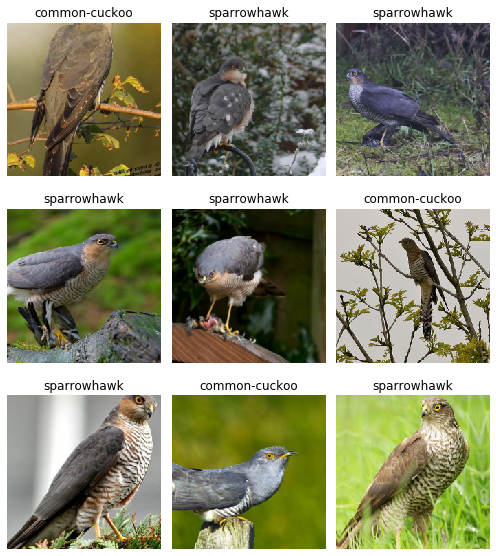

In [7]:
data.show_batch(rows=3, figsize=(7,8))

### Train model

In [8]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [9]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.937877,0.504087,0.200000,00:04
1,0.668006,0.548324,0.176471,00:04
2,0.508730,0.489883,0.129412,00:03
3,0.398318,0.451295,0.117647,00:03


In [10]:
learn.save('stage-1')

In [11]:
learn.unfreeze()

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


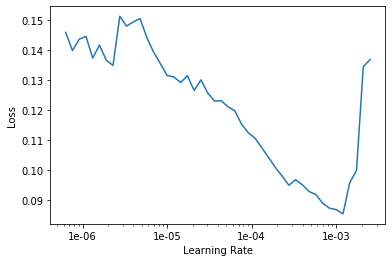

In [13]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [14]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.142893,0.418947,0.129412,00:03
1,0.138072,0.424113,0.105882,00:03
2,0.116746,0.406600,0.082353,00:04
3,0.097337,0.409089,0.094118,00:03
4,0.092696,0.399641,0.082353,00:03


In [15]:
learn.save('stage-2')

### Interpretation

In [16]:
learn.load('stage-2');

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

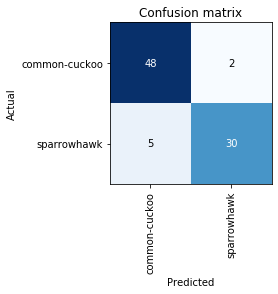

In [18]:
interp.plot_confusion_matrix()

### Cleaning Up
Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the ImageCleaner widget from fastai.widgets we can prune our top losses, removing photos that don't belong.

In [19]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with .from_toplosses. We then feed the top losses indexes and corresponding dataset to ImageCleaner.

Notice that the widget will not delete images directly from disk but it will create a new csv file cleaned.csv from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the ds_type param which no longer has any effect. See [the thread](https://forums.fast.ai/t/duplicate-widget/30975/10) for more details.

In [20]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [21]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [22]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via /tree, not /lab. Running the ImageCleaner widget in Jupyter Lab is not currently supported.

Install a bunch of widgets, as seen in the HousePlantClassifier example (forked)

In [23]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

I got a lot of sparrowhark images, and hardly any common-cuckoo... a lot more appeared nearer the end.

If the code above does not show any GUI(contains images and buttons) rendered by widgets but only text output, that may caused by the configuration problem of ipywidgets. Try the solution in this link to solve it.

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. ImageCleaner will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from top_losses.ImageCleaner(ds, idxs)

You can also find duplicates in your dataset and delete them! To do this, you need to run .from_similars to get the potential duplicates' ids and then run ImageCleaner with duplicates=True. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and learn_cln from the cleaned.csv file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [24]:
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                    .split_none()
                    .label_from_df()
                    .transform(get_transforms(), size=224)
                    .databunch()
      )

In [25]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');

In [26]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [27]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [28]:
data_cln = ImageDataBunch.from_csv(path, csv_labels='cleaned.csv', valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [31]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['common-cuckoo', 'sparrowhawk'], 2, 343, 85)

In [32]:
data_cln.classes, data_cln.c, len(data_cln.train_ds), len(data_cln.valid_ds)

(['common-cuckoo', 'sparrowhawk'], 2, 323, 80)

In [33]:
learn = cnn_learner(data_cln, models.resnet34, metrics=error_rate)

In [34]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.099115,0.229011,0.087500,00:04
1,0.735025,0.147684,0.037500,00:03
2,0.538013,0.138257,0.050000,00:04
3,0.422599,0.127103,0.050000,00:04


In [35]:
learn.save('stage-3')

### Putting your model in production
First thing first, let's export the content of our Learner object for production:

In [36]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [37]:
defaults.device = torch.device('cpu')

In [38]:
path = Path()
path

PosixPath('.')

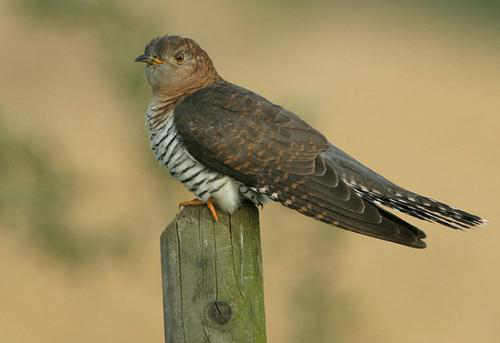

In [40]:
img = open_image(path/'data'/'common-cuckoo'/'000007.jpg')
img

We create our Learner in production enviromnent like this, just make sure that path contains the file 'export.pkl' from before.

In [41]:
learn = load_learner(path/'data')

In [42]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

Category common-cuckoo